# Ablation of non-EAP circuits

**Background:** A "TinySQL" model takes as input 1) An Instruction, which is an english data request sentence and 2) A Context, which is a SQL table create statement. The model outputs a Response, which is a SQL select statement.  

**Notebook purpose:** Do mean or zero ablation on the circuits of the models that were not selected through EAP.

**Notebook details:** This notebook:
- EAP for BM1CS3 semantic model.
- Requires a GITHUB_TOKEN secret to access Martian TinySQL code repository.
- Requires a HF_TOKEN secret to access Martian HuggingFace repository.
- Was developed under a grant provided by withmartian.com ( https://withmartian.com )
- Relies on the nnsight library. Also refer the https://nnsight.net/notebooks/tutorials/activation_patching/ tutorial

# Import libraries
Imports standard libraries. Do not read.

In [1]:
# https://nnsight.net/
# Access 0.4 prerelease version (as at Dec 2024)
#!pip install nnsight==0.4.0.dev0
!
!pip install nnsight==0.3.7 -q

In [2]:
!pip install pandas plotly -q

In [1]:
from IPython.display import clear_output
import einops
import torch
import plotly.express as px
import plotly.io as pio
# pio.renderers.default = "colab"

import nnsight
from nnsight import LanguageModel, util

In [2]:
from getpass import getpass
# from google.colab import userdata
import gc
import weakref

In [3]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import json
import datetime

In [4]:
!pip install datasets matplotlib seaborn -q

In [5]:
github_token = 'gh_'

!pip install --upgrade git+https://{github_token}@github.com/withmartian/TinySQL.git

import TinySQL as qts

  Cloning https://****@github.com/withmartian/TinySQL.git to /tmp/pip-req-build-c9l_ao2v
  Running command git clone --filter=blob:none --quiet 'https://****@github.com/withmartian/TinySQL.git' /tmp/pip-req-build-c9l_ao2v
  Resolved https://****@github.com/withmartian/TinySQL.git to commit b979a36c2b007358487454894873766d6031d55f
  Installing build dependencies ... one
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [6]:
clean_tokens = []
patching_results = []

In [7]:
# Key global "input" variables
clean_prompt = ""
corrupt_prompt = ""
clean_tokenizer_index = qts.UNKNOWN_VALUE # Tokenizer vocab index for clean word
corrupt_tokenizer_index = qts.UNKNOWN_VALUE # Tokenizer vocab index for corrupted word
answer_token_index = qts.UNKNOWN_VALUE # Token index in sql command answer of clean/corrupt word

# Key global "results" variables
clean_logit_diff = qts.UNKNOWN_VALUE
corrupt_logit_diff = qts.UNKNOWN_VALUE

In [8]:
def calculate_similarity(text1: str, text2: str) -> float:
    try:
        text1, text2 = text1.strip(), text2.strip()
        score = 0
        total_points = 0
        
        # Basic keywords
        has_select1, has_select2 = "SELECT" in text1, "SELECT" in text2
        has_from1, has_from2 = "FROM" in text1, "FROM" in text2
        has_order1, has_order2 = "ORDER BY" in text1, "ORDER BY" in text2
        has_as1, has_as2 = "AS" in text1, "AS" in text2
        
        # Points for matching presence/absence
        total_points += 4  # One point each for SELECT, FROM, ORDER BY, AS
        if (has_select1 and has_select2) or (not has_select1 and not has_select2):
            score += 1
        if (has_from1 and has_from2) or (not has_from1 and not has_from2):
            score += 1
        if (has_order1 and has_order2) or (not has_order1 and not has_order2):
            score += 1
        if (has_as1 and has_as2) or (not has_as1 and not has_as2):
            score += 1
            
        # AS count matching
        max_as = max(text1.count("AS"), text2.count("AS"))
        total_points += max_as
        score += min(text1.count("AS"), text2.count("AS"))
        
        # Table name comparison
        if has_from1 or has_from2:
            total_points += 1
            if has_from1 and has_from2:
                try:
                    table1 = text1[text1.find("FROM")+5:].split()[0]
                    table2 = text2[text2.find("FROM")+5:].split()[0]
                    if table1 == table2:
                        score += 1
                except:
                    pass
                    
        # ORDER BY comparison
        if has_order1 or has_order2:
            total_points += 1
            if has_order1 and has_order2:
                try:
                    order1 = text1[text1.find("ORDER BY")+9:].split()[0]
                    order2 = text2[text2.find("ORDER BY")+9:].split()[0]
                    if order1 == order2:
                        score += 1
                except:
                    pass
                    
        # Last AS word comparison
        if has_as1 or has_as2:
            total_points += 1
            if has_as1 and has_as2:
                try:
                    parts1 = text1.split("AS")
                    parts2 = text2.split("AS")
                    last_word1 = parts1[-1].strip().split()[0]
                    last_word2 = parts2[-1].strip().split()[0]
                    if last_word1 == last_word2:
                        score += 1
                except:
                    pass
                    
        # SELECT clauses comparison
        if has_select1 and has_from1 and has_select2 and has_from2:
            try:
                select_part1 = text1[text1.find("SELECT")+7:text1.find("FROM")].strip()
                select_part2 = text2[text2.find("SELECT")+7:text2.find("FROM")].strip()
                
                has_comma1 = "," in select_part1
                has_comma2 = "," in select_part2
                if has_comma1 or has_comma2:
                    total_points += 1
                    if has_comma1 and has_comma2:
                        score += 1
                
                clauses1 = [c.strip() for c in select_part1.split(",")]
                clauses2 = [c.strip() for c in select_part2.split(",")]
                
                max_clauses = max(len(clauses1), len(clauses2))
                total_points += max_clauses
                
                for clause1 in clauses1:
                    for clause2 in clauses2:
                        if clause1 == clause2:
                            score += 1
            except:
                pass
                
        return score / total_points if total_points > 0 else 0
    except:
        return 0  # Return 0 if anything goes wrong

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_ablation_comparison(mean_x, mean_y, zero_x, zero_y, baseline_value=1.0, save_path_prefix='mean_ablation_vs_zero'):
    """
    Plot comparison of mean and zero ablation results.
    
    Args:
        mean_x (list): X values for mean ablation
        mean_y (list): Y values for mean ablation
        zero_x (list): X values for zero ablation
        zero_y (list): Y values for zero ablation
        baseline_value (float): Value for the baseline horizontal line (default: 1.0)
        save_path_prefix (str): Prefix for saved files (default: 'mean_ablation_vs_zero')
    """
    # Set style
    sns.set_theme(style="whitegrid")
    sns.set_context("paper")
    colors = sns.color_palette("deep")
    mean_color = colors[2]  # Deep teal
    zero_color = colors[3]  # Deep purple
    
    # Create figure
    plt.figure(figsize=(10, 6))
    
    # Plot mean ablation
    plt.plot(mean_x, mean_y, 
             color=mean_color, 
             marker='o', 
             linestyle='-', 
             label='Mean Ablation', 
             linewidth=2.5, 
             markersize=8)
    
    # Plot zero ablation
    plt.plot(zero_x, zero_y, 
             color=zero_color, 
             marker='s', 
             linestyle='-', 
             label='Zero Ablation', 
             linewidth=2.5, 
             markersize=8)
    
    # Add baseline
    plt.axhline(y=baseline_value, 
                linestyle='--', 
                linewidth=1.5, 
                label='Model Without Ablation')
    
    # Customize plot
    plt.xlabel('Number of Active Layers', fontsize=11)
    plt.ylabel('Average Similarity', fontsize=11)
    plt.title('Comparison of Mean vs Zero Ablation', fontsize=12, pad=10)
    plt.legend(frameon=True, fontsize=10, loc='center right')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    # Save figures
    fig = plt.gcf()
    fig.savefig(f'{save_path_prefix}.pdf', format='pdf', dpi=300, bbox_inches='tight')
    fig.savefig(f'{save_path_prefix}_new.png', dpi=300, bbox_inches='tight')
    
    # Show plot
    plt.show()

# Select model, command set and feature to investigate


In [9]:
model_num = 1                   # 0=GPT2, 1=TinyStories, 2=Qwen, 3=Llama, 4=Granite, 5=SmolLM
cs_num = 3                        # 0=BaseModel, 1=CS1, 2=CS2 or 3=CS3
feature_name = qts.ENGTABLENAME   # ENGTABLENAME, ENGFIELDNAME, DEFTABLESTART, DEFTABLENAME, DEFFIELDNAME, DEFFIELDSEPARATOR
use_novel_names = False           # If True, we corrupt using words not found in the clean prompt or create sql e.g. "little" or "hammer"
use_synonyms_table = False
use_synonyms_field = False
batch_size = 100

# Load model

In [10]:
hf_token = 'hf_'

model = qts.load_tinysql_model(model_num, cs_num, auth_token=hf_token, synonym=True)
model_hf = qts.sql_interp_model_location(model_num, cs_num)
clear_output()
print(model)

GPTNeoForCausalLM(
  (transformer): GPTNeoModel(
    (wte): Embedding(50258, 1024)
    (wpe): Embedding(2048, 1024)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-1): 2 x GPTNeoBlock(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPTNeoAttention(
          (attention): GPTNeoSelfAttention(
            (attn_dropout): Dropout(p=0.0, inplace=False)
            (resid_dropout): Dropout(p=0.0, inplace=False)
            (k_proj): Linear(in_features=1024, out_features=1024, bias=False)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=False)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=False)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPTNeoMLP(
          (c_fc): Linear(in_features=1024, out_features=4096, bias=True)
          (c_proj): L

In [11]:
N_LAYERS, N_HEADS, D_MODEL, D_HEAD = qts.get_model_sizes(model_num, model)

N_LAYERS=2 N_HEADS=16 D_MODEL=1024 D_HEAD=64


# Generate clean and corrupt data

In [12]:
from collections import defaultdict
generator = qts.CorruptFeatureTestGenerator(model_num, cs_num, model.tokenizer, 
                                          use_novel_names=use_novel_names, 
                                          use_synonyms_field=use_synonyms_field, 
                                          use_synonyms_table=use_synonyms_table, 
                                          use_order_by=True,
                                          use_aggregates=True)

# First set of batches with batch_size
length_groups = defaultdict(list)
attempts = 0
max_attempts = 50
batch_size_mean = 200
while attempts < max_attempts:
    examples = generator.generate_feature_examples(feature_name, batch_size)
    
    for example in examples:
        clean_prompt = example.clean_BatchItem.get_alpaca_prompt() + example.clean_BatchItem.sql_statement
        prompt = clean_prompt.split('Response: ')[0] + 'Response: '
        ref_answer = clean_prompt.split('Response: ')[1]
        token_length = len(model.tokenizer(prompt)["input_ids"])
        
        length_groups[token_length].append({
            'prompt': prompt,
            'ref_answer': ref_answer
        })
    
    valid_groups = [length for length, group in length_groups.items() if len(group) >= batch_size]
    if len(valid_groups) >= 3:
        break
        
    attempts += 1

lengths = sorted([(len(group), length) for length, group in length_groups.items()], reverse=True)
target_lengths = [length for _, length in lengths[:3]]

batches = []
for length in target_lengths:
    batch_data = length_groups[length][:batch_size]
    batch = {
        'prompts': [item['prompt'] for item in batch_data],
        'ref_answers': [item['ref_answer'] for item in batch_data],
        'token_length': length
    }
    batches.append(batch)

# Second set of batches with batch_size_mean and same token lengths
length_groups_mean = defaultdict(list)
attempts = 0

while attempts < max_attempts:
    examples = generator.generate_feature_examples(feature_name, batch_size_mean)
    
    for example in examples:
        clean_prompt = example.clean_BatchItem.get_alpaca_prompt() + example.clean_BatchItem.sql_statement
        prompt = clean_prompt.split('Response: ')[0] + 'Response: '
        ref_answer = clean_prompt.split('Response: ')[1]
        token_length = len(model.tokenizer(prompt)["input_ids"])
        
        if token_length in target_lengths and len(length_groups_mean[token_length]) < batch_size_mean:
            length_groups_mean[token_length].append({
                'prompt': prompt,
                'ref_answer': ref_answer
            })
    
    if all(len(length_groups_mean[length]) >= batch_size_mean for length in target_lengths):
        break
        
    attempts += 1

batches_mean = []
for length in target_lengths:
    batch_data = length_groups_mean[length][:batch_size_mean]
    batch = {
        'prompts': [item['prompt'] for item in batch_data],
        'ref_answers': [item['ref_answer'] for item in batch_data],
        'token_length': length
    }
    batches_mean.append(batch)

print(f"Found {len(batches)} main batches with token lengths: {[b['token_length'] for b in batches]}")
print(f"Main batch sizes: {[len(b['prompts']) for b in batches]}")
print(f"Found {len(batches_mean)} mean batches with token lengths: {[b['token_length'] for b in batches_mean]}")
print(f"Mean batch sizes: {[len(b['prompts']) for b in batches_mean]}")

Found 3 main batches with token lengths: [32, 31, 33]
Main batch sizes: [100, 100, 100]
Found 3 mean batches with token lengths: [32, 31, 33]
Mean batch sizes: [200, 200, 200]


In [13]:
for batch in batches_mean:
    print(f"Batch with token length {batch['token_length']}")
    print(f"Number of examples: {batch['prompts'][0]}")

Batch with token length 32
Number of examples: ### Instruction: SELECT complete count category FROM people from oldest to newest category ### Context: CREATE TABLE people ( category TIME, type CHAR ) ### Response: 
Batch with token length 31
Number of examples: ### Instruction: Pull out label from users ranked in terms of label ### Context: CREATE TABLE users ( value TEXT, label JSON ) ### Response: 
Batch with token length 33
Number of examples: ### Instruction: From products, get me complete count status numerically by status ### Context: CREATE TABLE products ( status CHAR, label JSON ) ### Response: 


In [14]:
(batches_mean[0]['ref_answers'][0])

'SELECT COUNT(category) AS COUNT_category FROM people ORDER BY category ASC'

# Selective ablations whole model

In [15]:
def compute_head_means(model, prompt_texts):
    layer_means = []
    
    with model.generate(prompt_texts,max_new_tokens=100, pad_token_id=model.tokenizer.eos_token_id, temperature=0.5, 
                        top_p=0.9, eos_token_id=model.tokenizer.eos_token_id, do_sample=True, early_stopping=True) as tracer:
        
        for layer_idx in range(len(model.transformer.h)):
            layer_output = model.transformer.h[layer_idx].attn.output[0]
            
            output_reshaped = einops.rearrange(
                layer_output, 
                'b s (nh dh) -> b s nh dh',
                nh=N_HEADS
            )
            
            # Calculate mean across batch dimension
            head_means = output_reshaped.mean(dim=0)  # Shape: [s, nh, dh]
            layer_means.append(head_means.save())
            
    return layer_means

def mean_heads_ablation(model, prompt_text, target_layers, heads_per_layer, layer_means, mean=True):
    
    
    with model.generate(prompt_text,max_new_tokens=100, pad_token_id=model.tokenizer.eos_token_id, temperature=0.5, 
                        top_p=0.9, eos_token_id=model.tokenizer.eos_token_id, do_sample=True, early_stopping=True) as tracer:
        
        hidden_states = []
        for layer_idx in target_layers:
            # Get initial hidden states
            layer_output = model.transformer.h[layer_idx].attn.output[0]
            target_heads = heads_per_layer[layer_idx]
            
            # Reshape for head manipulation
            output_reshaped = einops.rearrange(
                layer_output, 
                'b s (nh dh) -> b s nh dh',
                nh=N_HEADS
            )
            
            head_means = layer_means[layer_idx]  # Shape: [s, nh, dh]
            
            # Replace non-target heads with their means
            for head_idx in range(N_HEADS):
                if head_idx not in target_heads:
                    # Replace with saved means while preserving sequence position
                    if mean:
                        output_reshaped[:, :, head_idx, :] = head_means[:, head_idx, :].unsqueeze(0)
                    else:
                        output_reshaped[:, :, head_idx, :] = torch.zeros_like(head_means[:, head_idx, :].unsqueeze(0))
            
            # Reshape back and modify layer output
            modified_output = einops.rearrange(
                output_reshaped,
                'b s nh dh -> b s (nh dh)', 
                nh=N_HEADS
            )
            model.transformer.h[layer_idx].attn.output = (modified_output,) + model.transformer.h[layer_idx].attn.output[1:]
            
            # Save hidden states for each step
            hidden_states.append(model.transformer.h[layer_idx].output[0].save())

        
        out = model.generator.output.save()
        
    return hidden_states, out

In [72]:
heads_per_layer = {
   0: [0, 1, 2, 3, 4, 6, 7, 11, 13, 14],
   1: [1, 2, 3, 5,  7, 8, 11, 15]
}



In [16]:
batch_idx = 0
layer_means = compute_head_means(model, batches_mean[batch_idx]['prompts'])

You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/opt/conda/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:676: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


In [17]:
target_layers = [0, 1]
heads_per_layer = {
   0: list(range(N_HEADS)),
   1: list(range(N_HEADS))
}

# Select which batch to use (0, 1, or 2)
batch_idx = 0
prompts = batches[batch_idx]['prompts']
ref_answers = batches[batch_idx]['ref_answers']

results = []
for i, prompt in enumerate(prompts):
   hidden_states, output = mean_heads_ablation(model, prompt, target_layers, heads_per_layer, layer_means, mean=False)
   gen_text = model.tokenizer.decode(output[0], skip_special_tokens=True).split('Response: ')[1]
   similarity = calculate_similarity(gen_text, ref_answers[i])
   results.append({
       'output': gen_text, 
       'similarity': similarity
   })

In [18]:
total_similarity = sum(r['similarity'] for r in results)
avg_similarity = total_similarity / len(results)
print(f"Average similarity: {avg_similarity}")

Average similarity: 0.7348985458985458


In [52]:
target_layers = [0, 1]
heads_per_layer = {
   0: [0, 1, 2, 3, 4, 6, 7, 11, 13, 14],
   1: [1, 2, 3, 5,  7, 8, 11, 15]
}

# Select which batch to use (0, 1, or 2)
batch_idx = 0
prompts = batches[batch_idx]['prompts']
ref_answers = batches[batch_idx]['ref_answers']

results = []
for i, prompt in enumerate(prompts):
   hidden_states, output = mean_heads_ablation(model, prompt, target_layers, heads_per_layer, layer_means, mean=False)
   gen_text = model.tokenizer.decode(output[0], skip_special_tokens=True).split('Response: ')[1]
   similarity = calculate_similarity(gen_text, ref_answers[i])
   results.append({
       'output': gen_text, 
       'similarity': similarity
   })

/opt/conda/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:676: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


In [53]:
for i, prompt in enumerate(prompts):
    print(results[i]['output']+'\n', prompt + '\n', ref_answers[i]+'\n\n')

SELECT COUNT(file_size) AS COUNT_file_size FROM items 
 ### Instruction: Share how many size from items beginning with the most size ### Context: CREATE TABLE items ( total CHAR, size JSON ) ### Response: 
 SELECT COUNT(size) AS COUNT_size FROM items ORDER BY size DESC


SELECT COUNT(name) AS COUNT_name, rank FROM users ORDER BY ASC mac_address ASC
 ### Instruction: Inside users, find number of title date ordered by title ### Context: CREATE TABLE users ( category TEXT, title JSON ) ### Response: 
 SELECT COUNT(title) AS COUNT_title FROM users ORDER BY title ASC


SELECT MIN(summary) AS MIN_summary FROM inventory ORDER BY DESC city DESC
 ### Instruction: Output least expensive value from inventory ORDER BY DESC value ### Context: CREATE TABLE inventory ( color INT, value TEXT ) ### Response: 
 SELECT MIN(value) AS MIN_value FROM inventory ORDER BY value DESC


SELECT value FROM users ORDER BY DESC city DESC
 ### Instruction: Starting with users, give me value prioritized by value ### C

In [20]:
prompts_mean = batches_mean[batch_idx]['prompts']
prompts = batches[batch_idx]['prompts']
ref_answers = batches[batch_idx]['ref_answers']

In [21]:
base_heads_per_layer = {
   0: [0, 1, 2, 3, 4, 6, 7, 11, 13, 14],
   1: [1, 2, 3, 5,  7, 8, 11, 15]
}

target_layers = [0, 1]

layer_0_mean_results = []
layer_0_zero_results = []
layer_1_mean_results = []
layer_1_zero_results = []

# Test Layer 0 (keeping Layer 1 intact)
print("\nTesting Layer 0:")
heads_0 = base_heads_per_layer[0]
for num_heads in range(1, len(heads_0) + 1):
    current_heads_0 = heads_0[:num_heads]
    print(f"\nTesting with Layer 0 heads: {current_heads_0}")
    
    # Keep all Layer 1 heads active while testing Layer 0
    current_heads_dict = {
        0: current_heads_0,
        1: base_heads_per_layer[1]  # All heads in layer 1
    }
    
    # Test with mean ablation
    results = []
    for i, prompt in enumerate(prompts):
        hidden_states, output = mean_heads_ablation(model, prompt, target_layers, current_heads_dict, layer_means, mean=True)
        gen_text = model.tokenizer.decode(output[0]).split('Response: ')[1]
        similarity = calculate_similarity(gen_text, ref_answers[i])
        results.append({
            'output': gen_text,
            'similarity': similarity
        })
    
    avg_similarity = sum(r['similarity'] for r in results) / len(results)
    layer_0_mean_results.append({
        'num_heads': num_heads,
        'heads': current_heads_0,
        'avg_similarity': avg_similarity,
        'detailed_results': results
    })
    
    # Test with zero ablation
    results = []
    for i, prompt in enumerate(prompts):
        hidden_states, output = mean_heads_ablation(model, prompt, target_layers, current_heads_dict, layer_means, mean=False)
        gen_text = model.tokenizer.decode(output[0]).split('Response: ')[1]
        similarity = calculate_similarity(gen_text, ref_answers[i])
        results.append({
            'output': gen_text,
            'similarity': similarity
        })
    
    avg_similarity = sum(r['similarity'] for r in results) / len(results)
    layer_0_zero_results.append({
        'num_heads': num_heads,
        'heads': current_heads_0,
        'avg_similarity': avg_similarity,
        'detailed_results': results
    })

# Test Layer 1 (keeping Layer 0 intact)
print("\nTesting Layer 1:")
heads_1 = base_heads_per_layer[1]
for num_heads in range(1, len(heads_1) + 1):
    current_heads_1 = heads_1[:num_heads]
    print(f"\nTesting with Layer 1 heads: {current_heads_1}")
    
    # Keep all Layer 0 heads active while testing Layer 1
    current_heads_dict = {
        0: base_heads_per_layer[0],  # All heads in layer 0
        1: current_heads_1
    }
    
    # Test with mean ablation
    results = []
    for i, prompt in enumerate(prompts):
        hidden_states, output = mean_heads_ablation(model, prompt, target_layers, current_heads_dict, layer_means, mean=True)
        gen_text = model.tokenizer.decode(output[0]).split('Response: ')[1]
        similarity = calculate_similarity(gen_text, ref_answers[i])
        results.append({
            'output': gen_text,
            'similarity': similarity
        })
    
    avg_similarity = sum(r['similarity'] for r in results) / len(results)
    layer_1_mean_results.append({
        'num_heads': num_heads,
        'heads': current_heads_1,
        'avg_similarity': avg_similarity,
        'detailed_results': results
    })
    
    # Test with zero ablation
    results = []
    for i, prompt in enumerate(prompts):
        hidden_states, output = mean_heads_ablation(model, prompt, target_layers, current_heads_dict, layer_means, mean=False)
        gen_text = model.tokenizer.decode(output[0]).split('Response: ')[1]
        similarity = calculate_similarity(gen_text, ref_answers[i])
        results.append({
            'output': gen_text,
            'similarity': similarity
        })
    
    avg_similarity = sum(r['similarity'] for r in results) / len(results)
    layer_1_zero_results.append({
        'num_heads': num_heads,
        'heads': current_heads_1,
        'avg_similarity': avg_similarity,
        'detailed_results': results
    })


Testing Layer 0:

Testing with Layer 0 heads: [0]

Testing with Layer 0 heads: [0, 1]

Testing with Layer 0 heads: [0, 1, 2]

Testing with Layer 0 heads: [0, 1, 2, 3]

Testing with Layer 0 heads: [0, 1, 2, 3, 4]

Testing with Layer 0 heads: [0, 1, 2, 3, 4, 6]

Testing with Layer 0 heads: [0, 1, 2, 3, 4, 6, 7]

Testing with Layer 0 heads: [0, 1, 2, 3, 4, 6, 7, 11]

Testing with Layer 0 heads: [0, 1, 2, 3, 4, 6, 7, 11, 13]

Testing with Layer 0 heads: [0, 1, 2, 3, 4, 6, 7, 11, 13, 14]

Testing Layer 1:

Testing with Layer 1 heads: [1]

Testing with Layer 1 heads: [1, 2]

Testing with Layer 1 heads: [1, 2, 3]

Testing with Layer 1 heads: [1, 2, 3, 5]

Testing with Layer 1 heads: [1, 2, 3, 5, 7]

Testing with Layer 1 heads: [1, 2, 3, 5, 7, 8]

Testing with Layer 1 heads: [1, 2, 3, 5, 7, 8, 11]

Testing with Layer 1 heads: [1, 2, 3, 5, 7, 8, 11, 15]


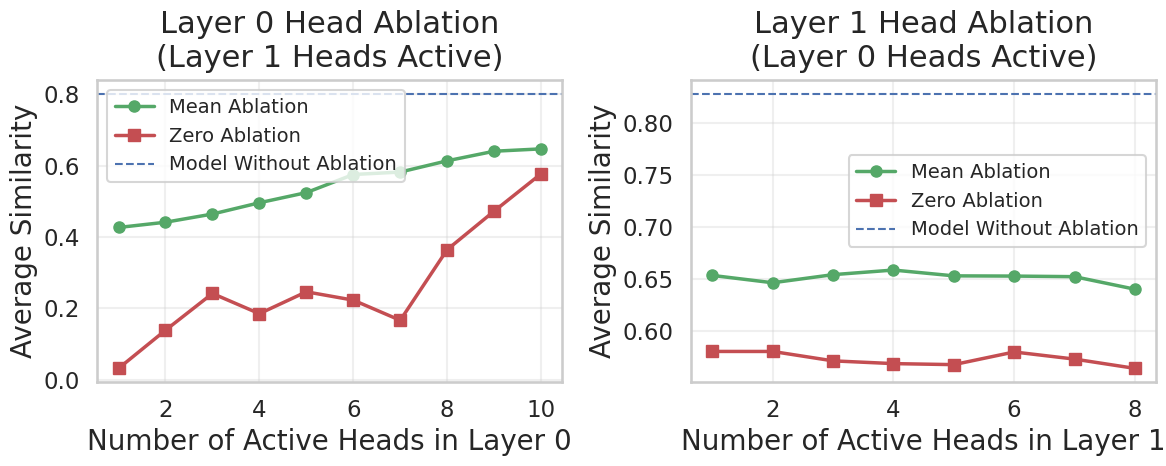

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
sns.set_context("talk")  # Larger font size context
colors = sns.color_palette("deep")
mean_color = colors[2] 
zero_color = colors[3]  
plt.figure(figsize=(12, 5))  # Keep the figure size the same

# Plot for Layer 0
plt.subplot(1, 2, 1)
plt.plot([r['num_heads'] for r in layer_0_mean_results],
         [r['avg_similarity'] for r in layer_0_mean_results],
         color=mean_color, marker='o', linestyle='-',
         label='Mean Ablation', linewidth=2.5, markersize=8)
plt.plot([r['num_heads'] for r in layer_0_zero_results],
         [r['avg_similarity'] for r in layer_0_zero_results],
         color=zero_color, marker='s', linestyle='-',
         label='Zero Ablation', linewidth=2.5, markersize=8)
plt.axhline(y=0.8, linestyle='--', linewidth=1.5, label='Model Without Ablation')  
plt.xlabel('Number of Active Heads in Layer 0', fontsize=20)
plt.ylabel('Average Similarity', fontsize=20)
plt.title('Layer 0 Head Ablation\n(Layer 1 Heads Active)', fontsize=22, pad=10)
# Moved legend to upper left
plt.legend(frameon=True, fontsize=14, loc='upper left')  
plt.grid(True, alpha=0.3)

# Plot for Layer 1
plt.subplot(1, 2, 2)
plt.plot([r['num_heads'] for r in layer_1_mean_results],
         [r['avg_similarity'] for r in layer_1_mean_results],
         color=mean_color, marker='o', linestyle='-',
         label='Mean Ablation', linewidth=2.5, markersize=8)
plt.plot([r['num_heads'] for r in layer_1_zero_results],
         [r['avg_similarity'] for r in layer_1_zero_results],
         color=zero_color, marker='s', linestyle='-',
         label='Zero Ablation', linewidth=2.5, markersize=8)
plt.axhline(y=0.8275, linestyle='--', linewidth=1.5, label='Model Without Ablation')  
plt.xlabel('Number of Active Heads in Layer 1', fontsize=20)
plt.ylabel('Average Similarity', fontsize=20)
plt.title('Layer 1 Head Ablation\n(Layer 0 Heads Active)', fontsize=22, pad=10)
# Moved legend to upper right
plt.legend(frameon=True, fontsize=14, loc='center right', bbox_to_anchor=(1.0, 0.6))
plt.grid(True, alpha=0.3)

plt.tight_layout()
fig = plt.gcf()
fig.savefig('ablation_results_bm1cs3->cs3.pdf', format='pdf', dpi=300, bbox_inches='tight')
fig.savefig('ablation_results_bm1cs3->cs3.png', dpi=300, bbox_inches='tight')
plt.show()

# global ablation

In [103]:
def compute_layer_means_all(model, prompt_texts):
    """Compute means for both attention and MLP outputs across samples."""
    attn_means = []
    mlp_means = []
    with model.generate(prompt_texts, max_new_tokens=7) as tracer:
        for layer_idx in range(N_LAYERS):            
            mlp_output = model.transformer.h[layer_idx].mlp.output
            mlp_mean = mlp_output.mean(dim=0)  # Mean across batch dim
            mlp_means.append(mlp_mean.save())
            
    return attn_means, mlp_means

def mean_ablation_all(model, prompt_text, target_layers, layer_means):
    """Apply mean ablation only to layers NOT in target_layers."""
    attn_means, mlp_means = layer_means
    
    with model.generate(prompt_text, max_new_tokens=7) as tracer:
        hidden_states = []
        for layer_idx in range(N_LAYERS):
            original_mlp = model.transformer.h[layer_idx].mlp.output
            
            if layer_idx not in target_layers:
                mlp_mean = mlp_means[layer_idx]
                
                modified_mlp = mlp_mean.unsqueeze(0).expand_as(original_mlp)
                
                model.transformer.h[layer_idx].mlp.output = modified_mlp
            
            hidden_states.append(model.transformer.h[layer_idx].output[0].save())
            
        out = model.generator.output.save()
        
    return hidden_states, out


In [116]:
def zero_ablation_all(model, prompt_text, target_layers):
    """Apply zero ablation only to layers NOT in target_layers."""
    with model.generate(prompt_text, max_new_tokens=7) as tracer:
        hidden_states = []
        for layer_idx in range(N_LAYERS):
            # Get original outputs
            original_attn = model.transformer.h[layer_idx].output
            original_mlp = model.transformer.h[layer_idx].mlp.output
            
            if layer_idx not in target_layers:
                # For non-target layers, replace with zeros
                # Create zeros with same shape as original outputs
                zero_attn = torch.zeros_like(original_attn[0])
                zero_mlp = torch.zeros_like(original_mlp)
                
                # Update outputs with zeros
                model.transformer.h[layer_idx].output = (zero_attn,) + original_attn[1:]
                model.transformer.h[layer_idx].mlp.output = zero_mlp
            # Else: do nothing, keep original outputs for target layers
            
            # Store hidden states
            # hidden_states.append(model.model.layers[layer_idx].output[0].save())
            
        out = model.generator.output.save()
        
    return hidden_states, out

In [25]:
def zero_ablation_all(model, prompt_text, target_layers, all_output=False):
    """Apply zero ablation only to layers NOT in target_layers."""
    with model.generate(prompt_text, max_new_tokens=7, pad_token_id=model.tokenizer.eos_token_id, 
                       temperature=0.5, top_p=0.9, eos_token_id=model.tokenizer.eos_token_id, 
                       do_sample=True, early_stopping=True) as tracer:
        hidden_states = []
        for layer_idx in range(N_LAYERS):
            # Get original outputs
            original_out = model.transformer.h[layer_idx].output
            original_mlp = model.transformer.h[layer_idx].mlp.output
            
            if layer_idx not in target_layers:
                # For non-target layers, replace with zeros
                zeros_mlp = torch.zeros_like(original_mlp)
                model.transformer.h[layer_idx].mlp.output = zeros_mlp
                
                if all_output:
                    # Update outputs with zeros
                    zeros_out = torch.zeros_like(original_out[0])
                    model.transformer.h[layer_idx].output = (zeros_out,) + original_out[1:]
            
            # Store hidden states
            # layer_output = model.transformer.h[layer_idx].output
            #hidden_states.append((layer_output[0] if isinstance(layer_output, tuple) else layer_output).save())
            
        out = model.generator.output.save()
        
    return hidden_states, out

# Usage:
target_layers = {'All MLPs ablated': [], 'First MLP ablated': [1], 'Second MLP ablated': [0]}
zero_ablation_mlp_results = []
zero_ablation_all_results = []

print('Running MLP-only zero ablation...')
for key in list(target_layers.keys()):
    current_layer = target_layers[key]
    results = []  # Reset results for each key
    for i, prompt in enumerate(prompts):
        hidden_states, output = zero_ablation_all(model, prompt, current_layer, all_output=False)
        gen_text = model.tokenizer.decode(output[0], skip_special_tokens=True).split('Response: ')[1]
        similarity = calculate_similarity(gen_text, ref_answers[i])
        results.append({
            'output': gen_text, 
            'similarity': similarity
        })
    # Calculate average after all prompts for this key
    avg_similarity = sum(r['similarity'] for r in results) / len(results)
    zero_ablation_mlp_results.append({
        'key': key,
        'target_layers': current_layer,
        'avg_similarity': avg_similarity,
        'detailed_results': results.copy()
    })       

print('Now, all output')
for key in list(target_layers.keys()):
    current_layer = target_layers[key]
    results = []  # Reset results for each key
    for i, prompt in enumerate(prompts):
        hidden_states, output = zero_ablation_all(model, prompt, current_layer, all_output=True)
        gen_text = model.tokenizer.decode(output[0], skip_special_tokens=True).split('Response: ')[1]
        similarity = calculate_similarity(gen_text, ref_answers[i])
        results.append({
            'output': gen_text, 
            'similarity': similarity
        })
    # Calculate average after all prompts for this key
    avg_similarity = sum(r['similarity'] for r in results) / len(results)
    zero_ablation_all_results.append({
        'key': key,
        'target_layers': current_layer,
        'avg_similarity': avg_similarity,
        'detailed_results': results.copy()
    })

Running MLP-only zero ablation...


/opt/conda/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:676: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


Now, all output


In [32]:
def compute_layer_means_all(model, prompt_texts):
    """Compute means for both attention and MLP outputs across samples."""
    out_means = []
    mlp_means = []
    
    with model.generate(prompt_texts, max_new_tokens=7) as tracer:
        for layer_idx in range(N_LAYERS):
            # Get attention output and compute mean
            out_output = model.transformer.h[layer_idx].output[0]
            out_mean = out_output.mean(dim=0)  # Mean across batch dim
            out_means.append(out_mean.save())
            
            # Get MLP output and compute mean
            mlp_output = model.transformer.h[layer_idx].mlp.output
            mlp_mean = mlp_output.mean(dim=0)  # Mean across batch dim
            mlp_means.append(mlp_mean.save())
            
    return out_means, mlp_means


def mean_ablation_all(model, prompt_text, target_layers, all_output=False):
    """Apply zero ablation only to layers NOT in target_layers."""
    
    out_means, mlp_means = compute_layer_means_all(model, prompts_mean)
    
    with model.generate(prompt_text, max_new_tokens=7, pad_token_id=model.tokenizer.eos_token_id, 
                       temperature=0.5, top_p=0.9, eos_token_id=model.tokenizer.eos_token_id, 
                       do_sample=True, early_stopping=True) as tracer:
        hidden_states = []
        for layer_idx in range(N_LAYERS):
            # Get original outputs
            original_out = model.transformer.h[layer_idx].output
            original_mlp = model.transformer.h[layer_idx].mlp.output
            
            if layer_idx not in target_layers:
                # For non-target layers, replace with zeros
                out_mean = out_means[layer_idx]
                mlp_mean = mlp_means[layer_idx]


                modified_out = out_mean.unsqueeze(0).expand_as(original_out[0])
                modified_mlp = mlp_mean.unsqueeze(0).expand_as(original_mlp)    
                
                model.transformer.h[layer_idx].mlp.output = modified_mlp                
                if all_output:
                    # Update outputs with zeros
                    model.transformer.h[layer_idx].output = (modified_out,) + original_out[1:]
            
            # Store hidden states
            # layer_output = model.transformer.h[layer_idx].output
            #hidden_states.append((layer_output[0] if isinstance(layer_output, tuple) else layer_output).save())
            
        out = model.generator.output.save()
        
    return hidden_states, out

# Usage:
target_layers = {'All MLPs ablated': [], 'First MLP ablated': [1], 'Second MLP ablated': [0]}
mean_ablation_mlp_results = []
mean_ablation_all_results = []

print('Running MLP-only zero ablation...')
for key in list(target_layers.keys()):
    current_layer = target_layers[key]
    results = []  # Reset results for each key
    for i, prompt in enumerate(prompts):
        hidden_states, output = mean_ablation_all(model, prompt, current_layer, all_output=False)
        gen_text = model.tokenizer.decode(output[0], skip_special_tokens=True).split('Response: ')[1]
        similarity = calculate_similarity(gen_text, ref_answers[i])
        results.append({
            'output': gen_text, 
            'similarity': similarity
        })
    # Calculate average after all prompts for this key
    avg_similarity = sum(r['similarity'] for r in results) / len(results)
    mean_ablation_mlp_results.append({
        'key': key,
        'target_layers': current_layer,
        'avg_similarity': avg_similarity,
        'detailed_results': results.copy()
    })       

print('Now, all output')
for key in list(target_layers.keys()):
    current_layer = target_layers[key]
    results = []  # Reset results for each key
    for i, prompt in enumerate(prompts):
        hidden_states, output = mean_ablation_all(model, prompt, current_layer, all_output=True)
        gen_text = model.tokenizer.decode(output[0], skip_special_tokens=True).split('Response: ')[1]
        similarity = calculate_similarity(gen_text, ref_answers[i])
        results.append({
            'output': gen_text, 
            'similarity': similarity
        })
    # Calculate average after all prompts for this key
    avg_similarity = sum(r['similarity'] for r in results) / len(results)
    mean_ablation_all_results.append({
        'key': key,
        'target_layers': current_layer,
        'avg_similarity': avg_similarity,
        'detailed_results': results.copy()
    })

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Running MLP-only zero ablation...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

Now, all output


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Function to plot ablation results
def plot_ablation_results(categories, mean_similarities, zero_similarities, save_path=None):
    sns.set_theme(style="whitegrid")
    sns.set_context("talk")  # Larger fonts for better visibility
    colors = sns.color_palette("deep")
    
    fig, ax = plt.subplots(figsize=(12, 8))  # Adjusted figure size
    
    x = np.arange(len(categories))
    width = 0.35
    
    # Plotting the bar charts
    rects1 = ax.bar(x - width/2, mean_similarities, width, 
                    label='Mean Ablation', color=colors[2])
    rects2 = ax.bar(x + width/2, zero_similarities, width,
                    label='Zero Ablation', color=colors[3])
    
    ax.axhline(y=0.74, linestyle='--', linewidth=2, label='Model Without Ablation')
    
    # Increase font size for axes and title
    ax.set_ylabel('Average Similarity', fontsize=24, labelpad=15)
    ax.set_title('Ablation Results Comparison', fontsize=28, pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(categories, fontsize=20)
    ax.legend(frameon=True, fontsize=20)
    
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.3f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=18)
    
    autolabel(rects1)
    autolabel(rects2)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(f'{save_path}.pdf', format='pdf', dpi=300, bbox_inches='tight')
        plt.savefig(f'{save_path}.png', dpi=300, bbox_inches='tight')
    
    plt.close(fig) 
    return fig


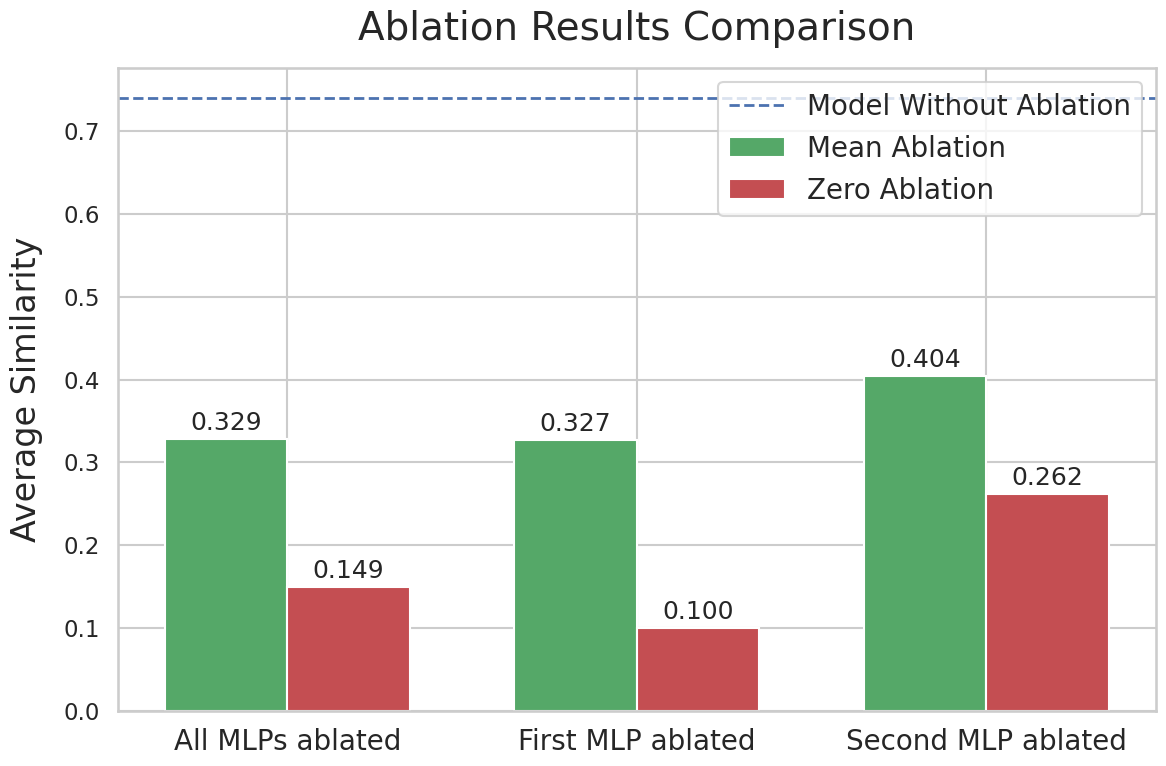

In [54]:
categories = ['All MLPs ablated', 'First MLP ablated', 'Second MLP ablated']
mean_mlp_avg = [mean_ablation_mlp_results[i]['avg_similarity'] for i in range(3)]
zero_mlp_avg = [zero_ablation_mlp_results[i]['avg_similarity'] for i in range(3)]

plot_ablation_results(categories, mean_mlp_avg, zero_mlp_avg, 'bm1cs3_cs3_ablation_mlp')

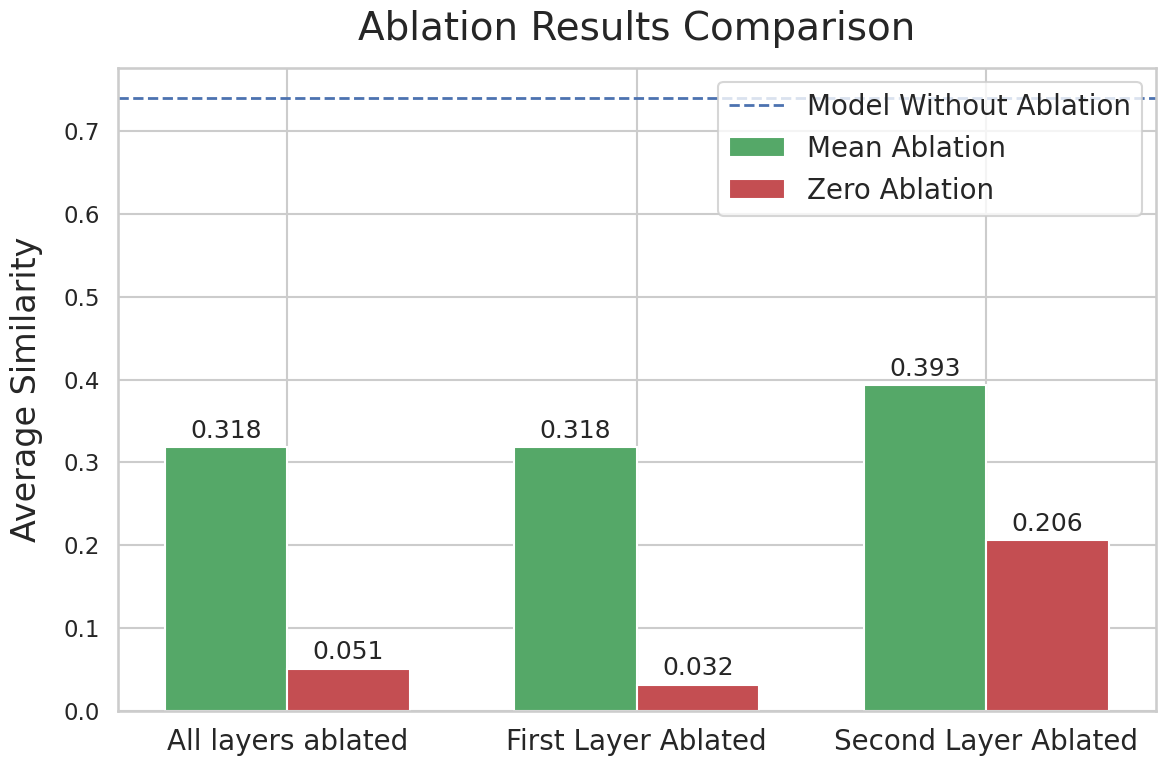

In [45]:
categories = ['All layers ablated', 'First Layer Ablated', 'Second Layer Ablated']
mean_all_avg = [mean_ablation_all_results[i]['avg_similarity'] for i in range(3)]
zero_all_avg = [zero_ablation_all_results[i]['avg_similarity'] for i in range(3)]

plot_ablation_results(categories, mean_all_avg, zero_all_avg, 'bm1cs3_cs3_ablation_all.png')

# Difference vectors

In [30]:
def compute_batch_means(model, prompts):
    """First compute means across multiple prompts."""
    N_HEADS = 16
    attn_means = []
    mlp_means = []
    
    with model.generate(prompts, max_new_tokens=7) as tracer:
        for layer_idx in range(len(model.transformer.h)):
            # Get attention and MLP outputs
            attn_output = model.transformer.h[layer_idx].attn.output[0]
            mlp_output = model.transformer.h[layer_idx].mlp.output
            
            # For attention, reshape to expose heads
            attn_reshaped = einops.rearrange(
                attn_output, 
                'b s (nh dh) -> b s nh dh',
                nh=N_HEADS
            )
            
            # Compute means across batch dimension
            attn_mean = attn_reshaped.mean(dim=0)  # Shape: [s, nh, dh]
            mlp_mean = mlp_output.mean(dim=0)      # Shape: [s, hidden_dim]
            
            attn_means.append(attn_mean.save())
            mlp_means.append(mlp_mean.save())
    
    return attn_means, mlp_means

def compute_residual_difference(model, prompt_text, attn_means, mlp_means):
    """Run mean ablation and compute difference between final and initial vectors."""
    N_HEADS = 16
    
    with model.generate(prompt_text, max_new_tokens=7) as tracer:
        # Save initial embeddings
        initial_embeddings = model.transformer.wte.output
        
        # Run through transformer with pre-computed means
        for layer_idx in range(len(model.transformer.h)):
            # Replace attention outputs with means
            original_attn = model.transformer.h[layer_idx].attn.output
            attn_mean = attn_means[layer_idx]
            attn_expanded = attn_mean.unsqueeze(0)  # Add batch dim
            modified_attn = einops.rearrange(
                attn_expanded,
                'b s nh dh -> b s (nh dh)', 
                nh=N_HEADS
            )
            model.transformer.h[layer_idx].attn.output = (modified_attn,) + original_attn[1:]
            
            # Replace MLP outputs with means
            mlp_mean = mlp_means[layer_idx]
            mlp_expanded = mlp_mean.unsqueeze(0)  # Add batch dim
            model.transformer.h[layer_idx].mlp.output = mlp_expanded
        
        # Get final vectors after last MLP
        final_vectors = model.transformer.h[-1].mlp.output
        
        # Compute and save difference vectors
        difference_vectors = (final_vectors - initial_embeddings).save()
        
    return difference_vectors

def apply_difference_vectors(model, prompt_text, difference_vectors):
    """Apply saved difference vectors directly to embeddings."""
    with model.generate(prompt_text, max_new_tokens=7) as tracer:
        # Get initial embeddings
        embeddings = model.transformer.wte.output
        
        # Add difference vectors
        modified_embeddings = embeddings + difference_vectors.expand_as(embeddings)
        
        # Apply final layer norm
        normalized = model.transformer.ln_f(modified_embeddings)
        
        # Now pass to language model head
        logits = model.lm_head(normalized)
        
        out = logits.save()
    
    return out

# First compute means across batch of prompts
print("Computing batch means...")
attn_means, mlp_means = compute_batch_means(model, prompts)

# Then compute difference vectors using mean ablation
print("Computing residual difference...")
difference_vectors = compute_residual_difference(model, prompts[0], attn_means, mlp_means)

# Finally, apply to new prompts
print("Testing on prompts...")
results = []
for i, prompt in enumerate(prompts):
    output = apply_difference_vectors(model, prompt, difference_vectors)
    gen_text = model.tokenizer.decode(torch.argmax(output[0], dim=-1))
    similarity = calculate_similarity(gen_text, ref_answers[i])
    results.append({
        'output': gen_text,
        'similarity': similarity
    })

# Print results
for i, result in enumerate(results[:3]):
    print(f"\nPrompt {i}:")
    print(f"Generated: {result['output']}")
    print(f"Similarity: {result['similarity']}")

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Computing batch means...
Computing residual difference...
Testing on prompts...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



Prompt 0:
Generated:  Instruction: In me is is, is from help api ### ### Context: CREATE TABLE products ( meta V, meta TEXT, ### Response: SELECT
Similarity: 0.2

Prompt 1:
Generated:  Instruction: In me is is, is from help api ### ### Context: CREATE TABLE products ( meta V, meta TEXT, ### Response: SELECT
Similarity: 0.2

Prompt 2:
Generated:  Instruction: In me is is, is from help api ### ### Context: CREATE TABLE products ( meta V, meta TEXT, ### Response: SELECT
Similarity: 0.2
